In [1]:
# start on: https://youtu.be/t3YJ5hKiMQ0?t=887

# Continue building PyTorch-like components
- Embedding
- Flatten
- Sequential

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Setup

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# character - integer mappings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build dataset
block_size = 3 # context length for characters

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and create new context
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [6]:
# training, dev and test sets
import random
random.seed(42)
random.shuffle(words)
# break points for a 80, 10, 10 split
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()] )

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


# Model

In [8]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out))/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

In [9]:
# similar to pytorch batchnorm1d

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        #parameters trained with backpropagation
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        #buffers (trianed with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdims=True) # batch mean
            xvar = x.var(0, keepdims=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # normalize unit variance
        self.out = self.gamma * xhat + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [10]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [11]:
torch.manual_seed(42);

In [12]:
n_embed = 10
n_hidden = 200

In [13]:
C = torch.randn((vocab_size, n_embed))

layers = [
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

In [14]:
# parameter init
with torch.no_grad():
    layers[-1].weight *= 0.1 # makes the layers less confident
    
parameters = [C] + [p for layer in layers for p in layer.parameters()]

# number of total parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


### Optimization

In [15]:
max_steps = 200000
batch_size = 32
lossi = []

In [16]:
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # selects index values for the batch
    
    # forward pass
    emb = C[Xb] # embedded characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors into (   ,    )
    
    for layer in layers:
        x = layer(x)
        
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update: SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track progress
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    lossi.append(loss.log10().item())

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


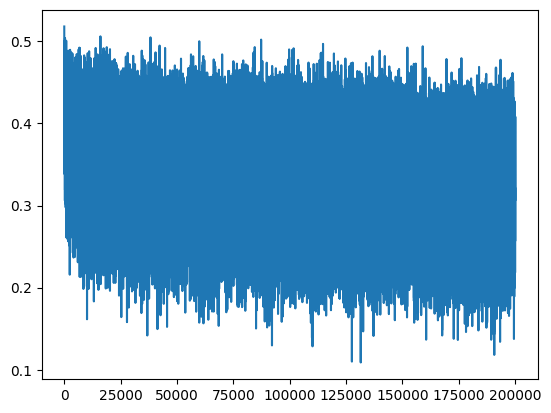

In [17]:
plt.plot(lossi) # small batch --> high variablility 

In [18]:
torch.tensor(lossi).view(-1, 1000).mean(1).shape # mean of rows of 1000

torch.Size([200])

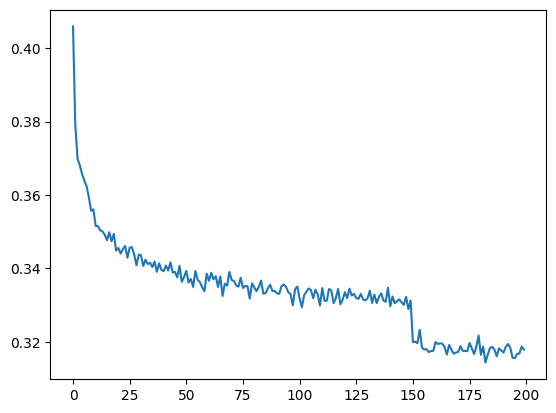

In [19]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

#### Evaluation

In [20]:
for layer in layers:
    layer.training = False

In [21]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    emb = C[x] # shape (N, block_size, n_embed)
    x = emb.view(emb.shape[0], -1)
    
    for layer in layers:
        x = layer(x)
        
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

In [22]:
split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065289974212646


#### Sample from the model

In [23]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        
        # forward pass of the nn
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        
        for layer in layers:
            x = layer(x)
            
        logits = x
        probs = F.softmax(logits, dim=1)
        
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        
        # shift the context window
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

ivon.
fanili.
thoommara.
kelo.
matyn.
leandr.
aleigh.
koldeniah.
prus.
carleen.
jah.
jorra.
alaya.
shonan.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.


## Improved code

In [24]:
# modules to conduct embedding and flattening the tensors used in training

class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim)) # replaces the C random starting values 
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]

In [25]:
class Flatten:
    
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

In [26]:
class Sequential:
    
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # return the parameters as a list
        # features of the child components
        return [p for layer in self.layers for p in layer.parameters()]

In [27]:
n_embed = 10
n_hidden = 200

max_steps = 200000
batch_size = 32
lossi = []

In [28]:
model = Sequential([
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

In [29]:
# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # makes the layers less confident
    
parameters = model.parameters()

# number of total parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [30]:
for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # selects index values for the batch
    
    # forward pass
    logits = model(Xb)
        
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update: SGD
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track progress
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    lossi.append(loss.log10().item())

      0/ 200000: 3.2877
  10000/ 200000: 2.4215
  20000/ 200000: 2.1593
  30000/ 200000: 2.2041
  40000/ 200000: 2.4939
  50000/ 200000: 2.5904
  60000/ 200000: 2.3319
  70000/ 200000: 1.6698
  80000/ 200000: 2.0560
  90000/ 200000: 2.1104
 100000/ 200000: 2.0435
 110000/ 200000: 2.1358
 120000/ 200000: 1.9564
 130000/ 200000: 2.0837
 140000/ 200000: 2.0470
 150000/ 200000: 2.3156
 160000/ 200000: 2.2258
 170000/ 200000: 2.2292
 180000/ 200000: 1.9476
 190000/ 200000: 2.0284


In [31]:
for layer in model.layers:
    layer.training = False

In [32]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    
    logits = model(x)
        
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

In [33]:
split_loss('train')
split_loss('val')

train 2.058614730834961
val 2.10583233833313


In [34]:
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
            
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        
        # shift the context window
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

jaxi.
amer.
khasean.
noma.
loriyon.
shika.
rudhika.
zhensleeie.
shia.
layden.
raiden.
mileah.
jacenesio.
rigt.
azi.
kaison.
romeer.
kimana.
mason.
mal.
